#ENGR 8140 - Advanced Deep Learning & Engineering Applications
## Assignment 2 - Image Classification
In this assignment, you will practice on image classification using the CIFAR-10 dataset.
The codes for data downloading and processing are provided below. Note the train dataset is further split into train_ds and val_ds and three dataloaders (i.e., train_loader, val_loader, and test_loader) are created for training, validation, and testing, respectively.

You will need to complete the following tasks:

(1) Code the MnasNet-A1 (shown below, ref: https://arxiv.org/abs/1807.11626) in PyTorch by following the similar coding style as the examples shown in "NB6_ModernCNNs.ipynb". Specifically, you will need to "modularize" your codes, i.e., define proper "classes" and/or "functions" for different blocks as shown in Figure 7 below (e.g., MBConv3, MBConv6, and SepConv) and then use them to construct your model architecture.

(2) Train the MnasNet-A1 using CIFAR-10.

(3) Evaluate your model and report performance on the test dataset.


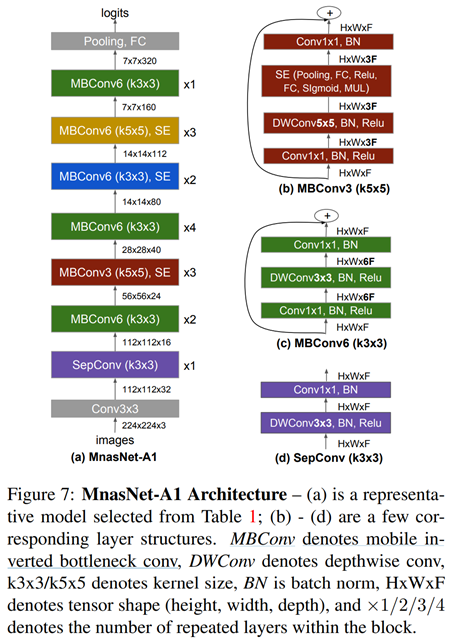

### Download datasets and create dataloaders

In [1]:
import torch
import torch.nn
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import numpy as np
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

normalize = transforms.Normalize(mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
                                 std=[x / 255.0 for x in [63.0, 62.1, 66.7]])

cf10_transforms = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

train = CIFAR10(root='./data', train=True, download=True, transform=cf10_transforms)
test = CIFAR10(root='./data', train=False, download=True, transform=cf10_transforms)

100%|██████████| 170498071/170498071 [00:04<00:00, 41671344.89it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [2]:
torch.cuda.set_device(0)

In [3]:
train.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [4]:
torch.manual_seed(42)
val_size = 5000
train_size = len(train) - val_size

In [5]:
train_ds, val_ds = random_split(train, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [6]:
batch_size=64

train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test, batch_size, num_workers=2, pin_memory=True)

images.shape: torch.Size([64, 3, 32, 32])


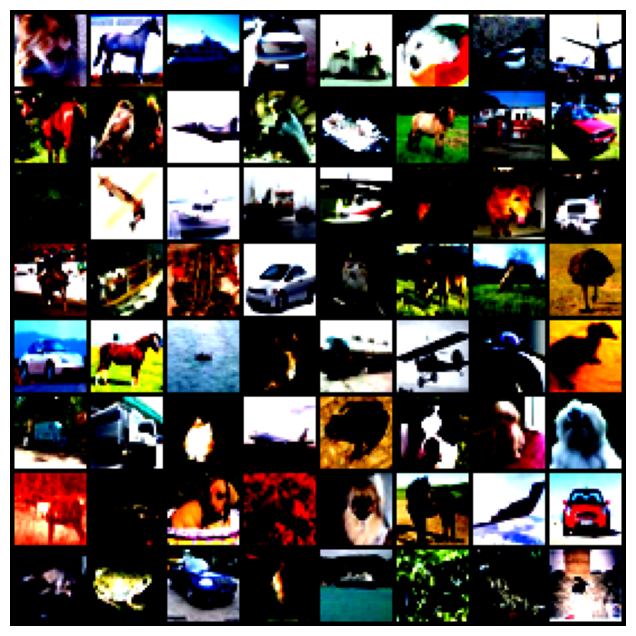

In [7]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(8,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))
    break

## Your codes go here:
### (1) Define the model

In [21]:
import torch
import torch.nn as nn
from torchsummary import summary

In [17]:
def SepConv(in_channels, out_channels, stride, padding, kernel_size=3):
    """
    Depthwise Separable Convolution Block.
    """
    layers = [
        nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=in_channels, bias=False),
        nn.BatchNorm2d(in_channels),
        nn.ReLU6(inplace=True),
        nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
        nn.BatchNorm2d(out_channels),
    ]
    return nn.Sequential(*layers)

In [45]:
class SEBlock(nn.Module):
    def __init__(self, channel, reduction_ratio=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction_ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction_ratio, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        y = self.avg_pool(x)
        y = y.view(y.size(0), -1)
        y = self.fc(y)
        y = y.view(y.size(0), y.size(1), 1, 1)
        return x * y

def se(channel):
    return nn.Sequential(
        SEBlock(channel)
    )

In [54]:
def MBConv3(in_channels, out_channels,kernel_size, expansion_factor=3, stride=2, squeeze_excitation=False):
    """
    Mobile Inverted Residual Bottleneck Block with expansion factor 3.
    """
    hidden_channels = in_channels * expansion_factor
    layers = [
        nn.Conv2d(in_channels, hidden_channels, kernel_size=1, bias=False),
        nn.BatchNorm2d(hidden_channels),
        nn.ReLU6(inplace=True),
        nn.Conv2d(hidden_channels, hidden_channels, kernel_size=kernel_size, stride=stride, padding=1, groups=hidden_channels, bias=False),
        nn.BatchNorm2d(hidden_channels),
        nn.ReLU6(inplace=True),
        nn.Conv2d(hidden_channels, out_channels, kernel_size=1, bias=False),
        nn.BatchNorm2d(out_channels),
    ]

    if squeeze_excitation:

        layer = nn.Sequential(*layers,
                              se(out_channels))
    else:
        layer = nn.Sequential(*layers)


    # print(layer)
    return layer

In [55]:
def MBConv6(in_channels, out_channels,kernel_size, expansion_factor=6, stride=2, squeeze_excitation=False):
    """
    Mobile Inverted Residual Bottleneck Block with expansion factor 6.
    """
    hidden_channels = in_channels * expansion_factor
    layers = [
        nn.Conv2d(in_channels, hidden_channels, kernel_size=1, bias=False),
        nn.BatchNorm2d(hidden_channels),
        nn.ReLU6(inplace=True),
        nn.Conv2d(hidden_channels, hidden_channels, kernel_size=kernel_size, stride=stride, padding=1, groups=hidden_channels, bias=False),
        nn.BatchNorm2d(hidden_channels),
        nn.ReLU6(inplace=True),
        nn.Conv2d(hidden_channels, out_channels, kernel_size=1, bias=False),
        nn.BatchNorm2d(out_channels),
    ]
    if squeeze_excitation:

        layer = nn.Sequential(*layers,
                              se(out_channels))
    else:
        layer = nn.Sequential(*layers)


    # print(layer)
    return layer


In [61]:
def MnasNetA1():
    """
    MnasNet architecture
    """
    model = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, groups=1),

        # SepConv (k3x3)
        SepConv(32, 16, kernel_size=3, stride=1, padding=1),

        # MBConv6 (k3x3)
        MBConv6(16, 24,kernel_size=3, stride=1),
        MBConv6(24, 24,kernel_size=3, stride=1),

        # MBConv3 (k5x5) (SE)
        MBConv3(24, 40,kernel_size=5, stride=1, squeeze_excitation=True),
        MBConv3(40, 40,kernel_size=5, stride=1, squeeze_excitation=True),
        MBConv3(40, 40,kernel_size=5, stride=1, squeeze_excitation=True),

        # MBConv6 (k3x3)
        MBConv6(40, 80,kernel_size=3, stride=1),
        MBConv6(80, 80,kernel_size=3, stride=1),
        MBConv6(80, 80,kernel_size=3, stride=1),
        MBConv6(80, 80,kernel_size=3, stride=1),

        # MBConv6 (k3x3) (SE)
        MBConv6(80, 112,kernel_size=3, stride=1, squeeze_excitation=True),
        MBConv6(112, 112,kernel_size=3, stride=1, squeeze_excitation=True),
        MBConv6(112, 160,kernel_size=5, stride=1, squeeze_excitation=True),
        MBConv6(160, 160,kernel_size=5, stride=1, squeeze_excitation=True),
        MBConv6(160, 160,kernel_size=5, stride=1, squeeze_excitation=True),

        # MBConv6 (k3x3)
        MBConv6(160, 320,kernel_size=3, stride=1),nn.ReLU(),

        # Pooling
        nn.AdaptiveAvgPool2d(1),

        # FC
        nn.Flatten(),nn.Linear(320, 1024), nn.ReLU(),
        nn.Linear(1024, 10),  # 10 classes for CIFAR-10
    )
    return model

mnasnet = MnasNetA1().cuda()
print(summary(mnasnet,(3,32,32),64,device='cuda'))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [64, 32, 16, 16]             896
            Conv2d-2           [64, 32, 16, 16]             288
       BatchNorm2d-3           [64, 32, 16, 16]              64
             ReLU6-4           [64, 32, 16, 16]               0
            Conv2d-5           [64, 16, 16, 16]             512
       BatchNorm2d-6           [64, 16, 16, 16]              32
            Conv2d-7           [64, 96, 16, 16]           1,536
       BatchNorm2d-8           [64, 96, 16, 16]             192
             ReLU6-9           [64, 96, 16, 16]               0
           Conv2d-10           [64, 96, 16, 16]             864
      BatchNorm2d-11           [64, 96, 16, 16]             192
            ReLU6-12           [64, 96, 16, 16]               0
           Conv2d-13           [64, 24, 16, 16]           2,304
      BatchNorm2d-14           [64, 24,

### (2) Train the model using train and val datasets

In [62]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnasnet.parameters(), lr=0.01)

In [63]:
# Training loop
loss_tr=[]
accu_tr=[]
loss_val=[]
accu_val=[]

num_epochs = 50
for epoch in range(num_epochs):
    mnasnet.train()
    count=0
    for images, labels in train_loader:

        images,labels = images.cuda(), labels.cuda()
        print(type(images), images.shape, type(labels), labels.shape)
        optimizer.zero_grad()
        outputs = mnasnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        count+=1
        print(f'epoch {epoch}, batch {count}')


    # Training eval:
    mnasnet.eval()
    train_loss = 0.0
    corr_tr = 0
    tot_tr = 0
    with torch.no_grad():
        for images, labels in train_loader:
            images,labels = images.cuda(), labels.cuda()
            outputs_tr = mnasnet(images)
            train_loss += criterion(outputs_tr, labels).item()
            _, predict_tr = torch.max(outputs_tr.data, 1)
            tot_tr += labels.size(0)
            corr_tr += (predict_tr == labels).sum().item()

    loss_tr.append(train_loss / len(train_loader))
    accu_tr.append(corr_tr / tot_tr)

    print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss / len(train_loader):.4f}, Accuracy: {100 * corr_tr / tot_tr:.2f}%")


    # Validation
    mnasnet.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images,labels = images.cuda(), labels.cuda()
            outputs = mnasnet(images)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Epoch [{epoch + 1}/{num_epochs}] - Validation Loss: {val_loss / len(val_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")

    loss_val.append(val_loss / len(val_loader))
    accu_val.append(correct / total)


Streaming output truncated to the last 5000 lines.
<class 'torch.Tensor'> torch.Size([64, 3, 32, 32]) <class 'torch.Tensor'> torch.Size([64])
epoch 46, batch 321
<class 'torch.Tensor'> torch.Size([64, 3, 32, 32]) <class 'torch.Tensor'> torch.Size([64])
epoch 46, batch 322
<class 'torch.Tensor'> torch.Size([64, 3, 32, 32]) <class 'torch.Tensor'> torch.Size([64])
epoch 46, batch 323
<class 'torch.Tensor'> torch.Size([64, 3, 32, 32]) <class 'torch.Tensor'> torch.Size([64])
epoch 46, batch 324
<class 'torch.Tensor'> torch.Size([64, 3, 32, 32]) <class 'torch.Tensor'> torch.Size([64])
epoch 46, batch 325
<class 'torch.Tensor'> torch.Size([64, 3, 32, 32]) <class 'torch.Tensor'> torch.Size([64])
epoch 46, batch 326
<class 'torch.Tensor'> torch.Size([64, 3, 32, 32]) <class 'torch.Tensor'> torch.Size([64])
epoch 46, batch 327
<class 'torch.Tensor'> torch.Size([64, 3, 32, 32]) <class 'torch.Tensor'> torch.Size([64])
epoch 46, batch 328
<class 'torch.Tensor'> torch.Size([64, 3, 32, 32]) <class 'to

In [64]:
print(f'Train loss: {loss_tr}, Train accuracy: {accu_tr}, Val loss: {loss_val}, Val Accuracy: {accu_val}')

Train loss: [1.7480295163325288, 1.6018899260935457, 1.6515903694724494, 1.4649714471941644, 1.6084372535009275, 1.2179789529605345, 1.0293662039224396, 1.0538998470557006, 0.9541477529670704, 0.8952659405767918, 0.8196043012748387, 0.9248086052777414, 0.9021460086699914, 1.286296104927632, 0.7811857022091069, 0.755386183546348, 0.6635308361781592, 0.626291089754721, 0.870894573205574, 0.5696431228848682, 0.5724258865018121, 0.5068840110166506, 0.5185560408810322, 0.7313566492362455, 0.6141479108482599, 0.4713073643136092, 0.6613836006938734, 0.4237703765075738, 0.4389874994839457, 0.4210964555386454, 0.4317670280156149, 0.7239472496704283, 0.4270627385174686, 0.4289927099069411, 0.4082075517878614, 0.43207549045539717, 0.4332860499641604, 0.458997593134303, 0.45138059327886865, 0.412019982828166, 0.410288476737068, 0.3706297296607359, 0.31704081899740477, 0.4343208538961004, 0.4053971729220145, 0.37264878739899193, 0.30878543203950604, 0.42113780429248104, 0.37212103770368476, 0.28003

In [65]:
from matplotlib import pyplot as plt

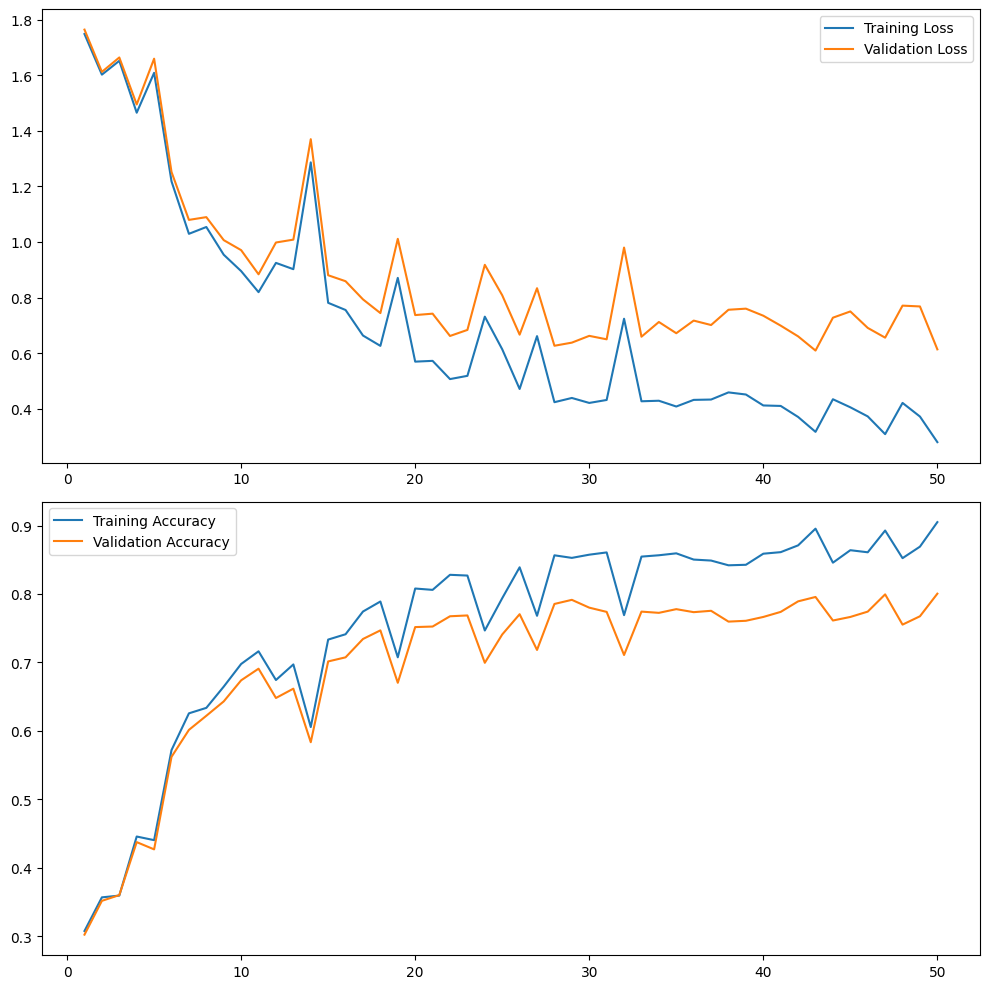

In [71]:
fig,ax = plt.subplots(2, figsize=(10,10))

epochs = np.arange(1,51)

ax[0].plot(epochs,np.array(loss_tr), label='Training Loss')
ax[0].plot(epochs,np.array(loss_val), label='Validation Loss')
ax[0].legend()


ax[1].plot(epochs,np.array(accu_tr), label='Training Accuracy')
ax[1].plot(epochs,np.array(accu_val), label='Validation Accuracy')
ax[1].legend()

plt.tight_layout()
plt.show()


### (3) Evaluate the model and report performance using the test dataset

In [72]:
mnasnet.eval()
test_correct = 0
test_total =  0
with torch.no_grad():
    for images, labels in test_loader:
        images,labels = images.cuda(), labels.cuda()
        outputs = mnasnet(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * test_correct / test_total:.2f}%")

Test Accuracy: 78.80%
